In [21]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import keras_ocr
import os
import io
import cv2 

from google.cloud import vision
from pytesseract import Output
from pytesseract import pytesseract as pt
from PIL import Image, ImageDraw
from glob import glob

In [11]:
fold_path = os.getenv('HOME')+'/aiffel/ocr_python/card/'
os.listdir(fold_path)

['StudentID_15.jpeg',
 'StudentID_7.jpeg',
 'StudentID_8.jpeg',
 'StudentID_16.jpeg',
 'images.jpeg',
 'StudentID_18.jpeg',
 'StudentID_12.jpeg',
 'card_1.png',
 'StudentID_14.jpeg',
 'images (3).jpeg',
 'StudentID_11.jpeg',
 'StudentID_13.jpeg',
 'images (6).jpeg',
 'images (1).jpeg',
 'StudentID_20.jpeg',
 'images (4).jpeg',
 'StudentID_17.jpeg',
 'images (5).jpeg',
 'images (2).jpeg',
 'StudentID_19.jpeg']

In [12]:
# def changeName(path, cName):
#     i = 1
#     for filename in os.listdir(path):
#         os.rename(path+filename, path+str(cName)+'_'+str(i)+'.jpeg')
#         i += 1

In [13]:
changeName(fold_path, 'Student')

images_path = glob(fold_path+'*.jpeg')
images_path

['/home/aiffel0042/aiffel/ocr_python/card/Student_1.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/card/Student_11.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/card/Student_15.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/card/Student_6.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/card/Student_18.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/card/Student_14.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/card/Student_10.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/card/Student_17.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/card/Student_16.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/card/Student_3.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/card/Student_7.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/card/Student_20.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/card/Student_13.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/card/Student_19.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/card/Student_8.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/card/Student_5.jpeg',
 '/home/aiffel0042/aiffel/ocr_python/card/Stud

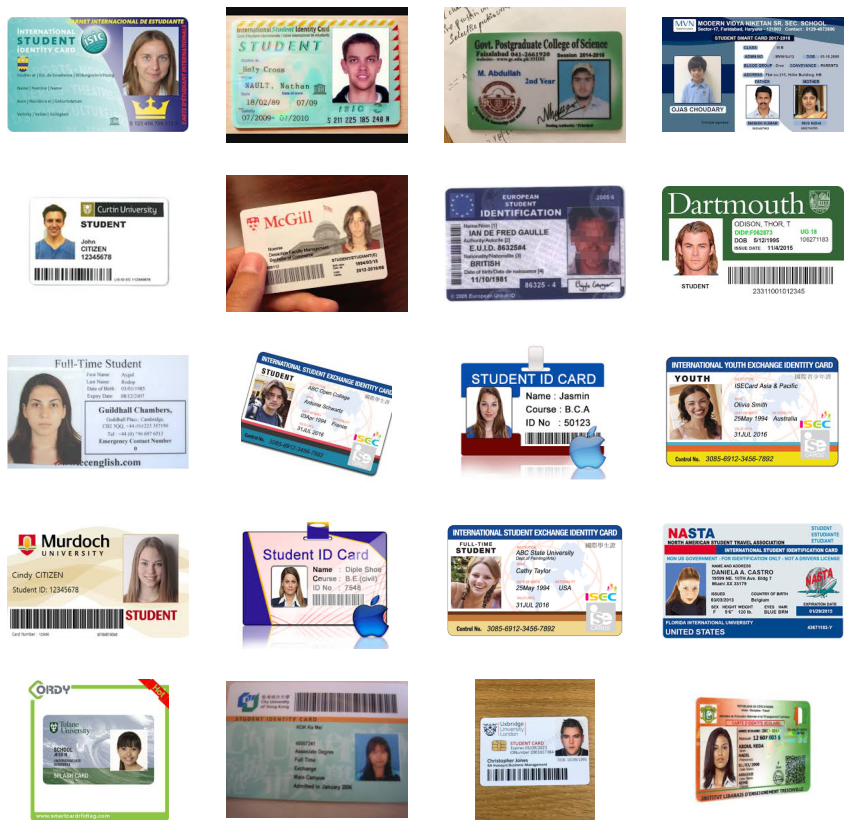

In [14]:
plt.figure(figsize=(15, 15))

for idx, image in enumerate(images_path):
    plt.subplot(5, 4, idx+1)
    im=img.imread(image)
    plt.imshow(im)
    plt.axis('off')

## OCR API

In [15]:
def draw_boxes(image, bounds, color):
    """Draw a border around the image using the hints in the vector list."""
    draw = ImageDraw.Draw(image)

    for bound in bounds:
        draw.polygon([
            bound.vertices[0].x, bound.vertices[0].y,
            bound.vertices[1].x, bound.vertices[1].y,
            bound.vertices[2].x, bound.vertices[2].y,
            bound.vertices[3].x, bound.vertices[3].y], None, color)
    return image

In [16]:
def detect_text(path):
    """Detects text in the file."""
    text_dec = []
    bounds = []
    client = vision.ImageAnnotatorClient()
    
    with io.open(path, 'rb') as image_file:
        content = image_file.read()
    
    s = os.path.splitext(path)
    s = os.path.split(s[0])
    name = s[1]
    
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations

    for text in texts:
        text_dec.append(text.description.replace('\n',''))
        vertices = text.bounding_poly
        bounds.append(vertices)
    
    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))
        
    return name, text_dec, bounds

In [17]:
# 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

ocr_img = []
ocr_dict = {}
# 입력 이미지 경로를 지정해 주세요.
path = '/home/aiffel0042/aiffel/ocr_python/card/card_3.jpeg'

# # 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
for path in images_path:
    name, text_dec, bounds = detect_text(path)
    ocr_dict[name] = text_dec
    image = Image.open(path)
    draw_boxes(image, bounds, 'red')
    ocr_img.append(image)

-rw-r--r-- 1 aiffel0042 aiffel0042 2346 10월  7 10:41 /home/aiffel0042/aiffel/ocr_python/my_google_api_key.json


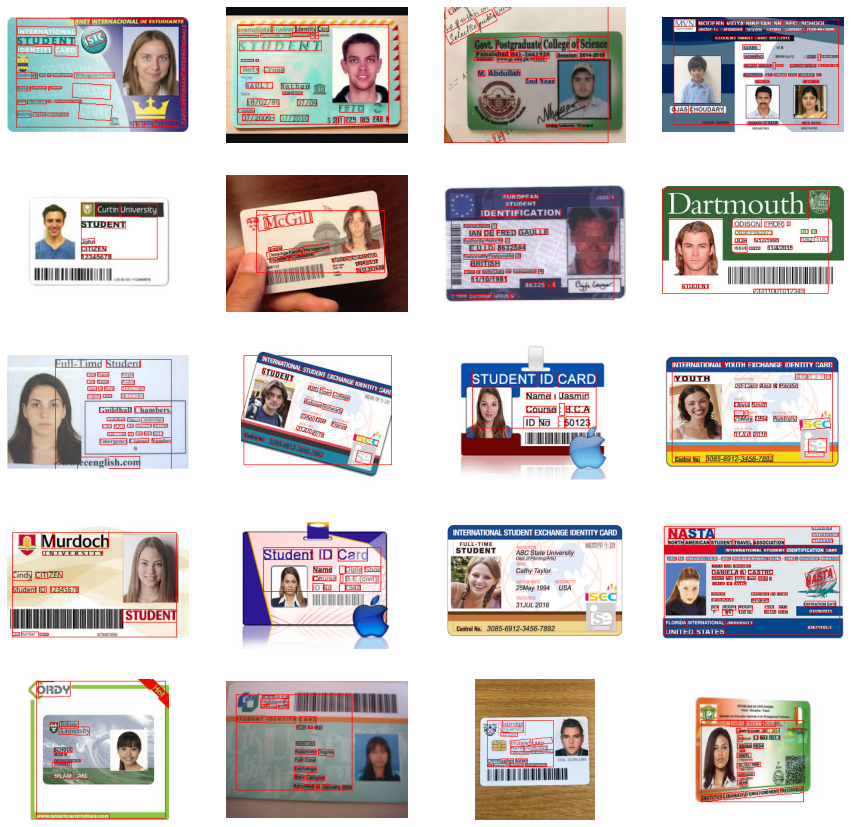

In [18]:
plt.figure(figsize=(15, 15))

for idx, img in enumerate(ocr_img):
    plt.subplot(5, 4, idx+1)
    plt.imshow(img)
    plt.axis('off')

## keras-ocr

In [19]:
# keras-ocr will automatically download pretrained
# weights for the detector and recognizer.
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /home/aiffel0042/.keras-ocr/craft_mlt_25k.h5
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Looking for /home/aiffel0042/.keras-ocr/crnn_kurapan.h5


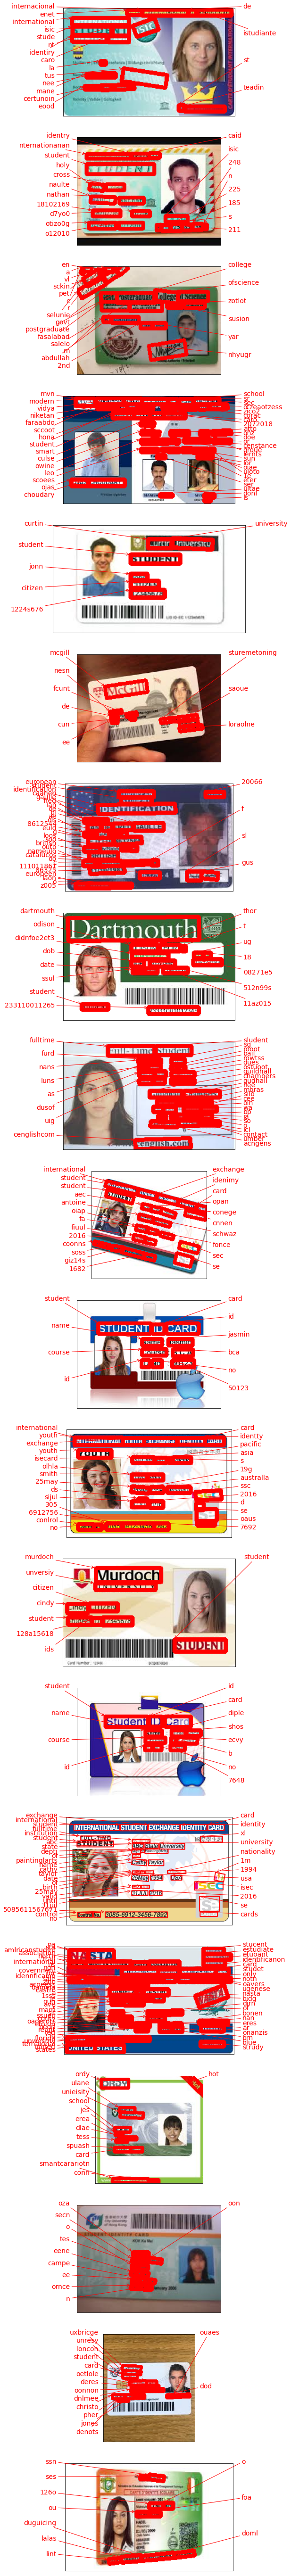

In [20]:
images = [ keras_ocr.tools.read(im) for im in images_path]
predictions = [pipeline.recognize([im]) for im in images_path]

# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(100, 100))

for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=predictions[idx][0], ax=ax)

## Tesseract

In [24]:
def crop_word_regions(image_path, output_path):
    s = os.path.splitext(image_path)
    s = os.path.split(s[0])
    name = s[1]
    output_path = output_path + name +'/'
    
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 11'
    image = Image.open(image_path)
    img = cv2.imread(image_path)
    
    d = pt.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    n_boxes = len(d['text'])
    for i in range(n_boxes):
        if int(d['conf'][i]) > 60:
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    top_level = max(d['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(d['level'])):
        level = d['level'][i]
    
        if level == top_level:
            left = d['left'][i]
            top = d['top'][i]
            width = d['width'][i]
            height = d['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return name, cropped_image_path_list, img


work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
output_path = work_dir + '/output/' 

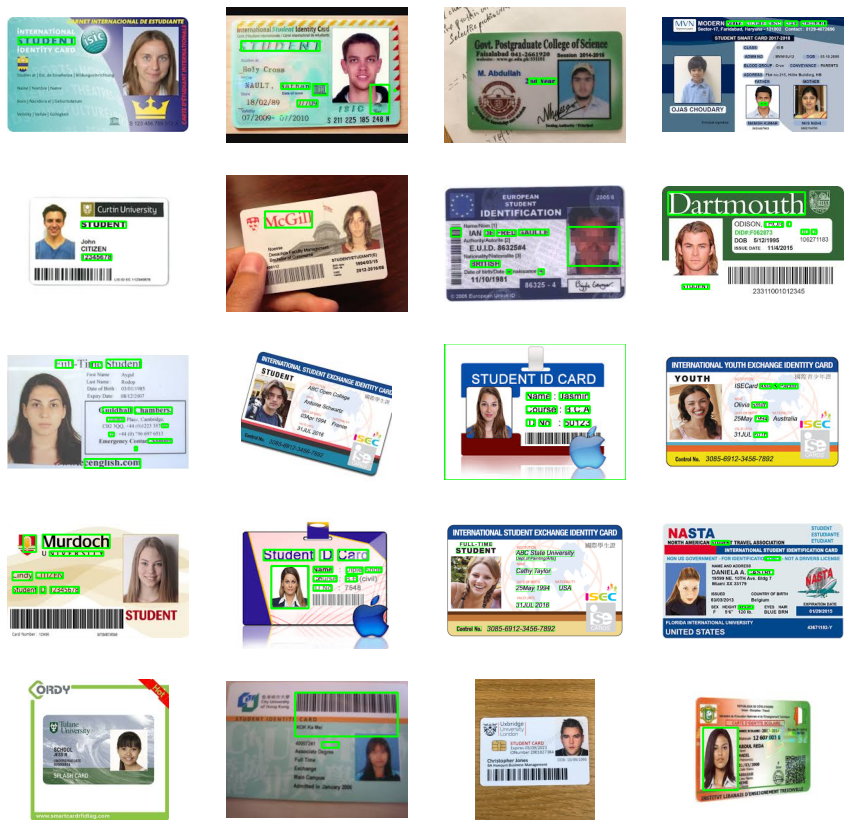

In [26]:
Tesser_dict = {}
img_dict = {}
plt.figure(figsize=(15, 15))

for idx, path in enumerate(images_path):    
    name, cropped_image_path_list, imgs = crop_word_regions(path, output_path)
    Tesser_dict[name] = cropped_image_path_list
    img_dict[name] = imgs
    plt.subplot(5, 4, idx+1)
    plt.imshow(imgs)
    plt.axis('off')

['Liverpool', 'Metroooitan', 'ee', 'University', 'Student', 'Card', '2018', 'cxpires 1', 'ID Numie', 'wit tec re re.', 'Management', 'School', 'Carol J', 'Shen', 'BL Pe', '', 'TM', 'TH', 'WU', 'Liverpool', 'Viet', 'University', 'etst MF']
Done


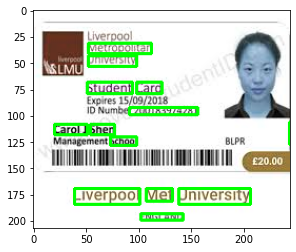

In [99]:
def recognize_images(cropped_image_path_list):
    test = []
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pt.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        test.append(recognized_data['text'].replace('\n', '').replace('\x0c',''))
        
    print(test)
    print("Done")

plt.imshow(img_dict['card_17'])
# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(Tesser_dict['card_17'])